In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [4]:
from tqdm import tqdm

In [5]:
df_train = pd.read_csv('df_with_outlier.csv')
df_test = pd.read_csv('df_test.csv')

In [6]:
df_train.head()
df_test.head()

,name,duration_min,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Untrue,0.050947,0,0.359551,Coal Chamber,Chamber Music,0.383,0.951,0,0.875150,...,0.2610,0.668,0.502470,206827,4.0,0.064532,0.063957,NaN,3.349057,industrial
1,High Roller,0.085323,0,0.460674,The Crystal Method,Vegas,0.464,0.579,5,0.755066,...,0.0992,0.140,0.780404,329733,4.0,0.156721,0.156562,NaN,1.279305,breakbeat
2,Na Tum Jano Na Hum (ReVibe),0.031138,0,0.449438,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.611,0.778,9,0.851548,...,0.1390,0.285,0.409049,136000,4.0,0.033523,0.032645,NaN,1.343558,indian
3,いじわるなハロー,0.062195,0,0.280899,Perfume,Cling Cling,0.500,0.958,0,0.920753,...,0.7320,0.955,0.590960,247040,4.0,0.088166,0.087941,NaN,3.349057,j-idol
4,Hit The Ceiling,0.051309,0,0.000000,Audio Bullys,Ego War,0.802,0.684,1,0.761679,...,0.2360,0.637,0.590792,208120,4.0,0.073751,0.073284,NaN,2.367412,breakbeat


### brief understanding test set

In [24]:
df_test.nunique()[df_test.nunique()<=20]; df_train.nunique()[df_train.nunique()<=20]

explicit           2
key               12
mode               2
time_signature     5
processing        12
genre             20
dtype: int64

In [25]:
df_test.value_counts('genre'); df_train.value_counts('genre')

genre
afrobeat         750
black-metal      750
study            750
spanish          750
sleep            750
mandopop         750
j-idol           750
j-dance          750
iranian          750
industrial       750
indian           750
idm              750
happy            750
forro            750
disney           750
chicago-house    750
breakbeat        750
brazil           750
bluegrass        750
techno           750
dtype: int64

### KNN

In [18]:
def numeric(df):
    
    nunique = df.nunique()
    cols = df.columns
    categorical = [col for col in cols if nunique[col] <= 20]
    objects = df.select_dtypes(include='object').columns
    
    df = df.drop(columns = set(list(objects)+categorical+['features_duration_ms','popularity_confidence']))
    
    return df

def plot_roc_cust(y_test, y_test_pred_proba):
    ax = plot_roc(y_test, y_test_pred_proba, figsize = (10,8), cmap = "binary", plot_micro=False)
    
    for line in ax.lines:
        line.set_linewidth(1)
    
    macro = ax.lines[-2]
    macro.set_color('#604abd')
    macro.set_linewidth(6)
    
    legend = ax.get_legend()
    legend.legendHandles[-1].set_color('#604abd')

    plt.show()
    
def plot_pres_recall(y_test, y_test_pred_proba):
    ax = plot_precision_recall(y_test, y_test_pred_proba, figsize = (10,8), cmap = "binary", plot_micro=False)
    
    for line in ax.lines:
        line.set_linewidth(1)
    
    macro = ax.lines[-2]
    macro.set_color('#9ec84a')
    macro.set_linewidth(3)
    
    
    legend = ax.get_legend()
    legend.legendHandles[-1].set_color('9ec84a')
    
    plt.legend(loc='lower right', fontsize='small') 
    plt.show()
    

In [8]:
X_train, X_test = numeric(df_train), numeric(df_test)
y_train, y_test = df_train['genre'], df_test['genre']

In [20]:
X_train.shape

(15000, 13)

In [165]:
%%time

n_neighbors = range(1, round(X_train.shape[0]**0.5)+10, 2)
scores = list()

for n in tqdm(n_neighbors):
    clf = KNeighborsClassifier(n_neighbors=n, metric="euclidean", weights="uniform")
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test)) # score = accuracy

100%|███████████████████████████████████████████| 66/66 [00:43<00:00,  1.53it/s]

CPU times: user 42.9 s, sys: 54.8 ms, total: 42.9 s
Wall time: 43.1 s


In [166]:
max_index = scores.index(max(scores))

In [13]:
n_neighbors[max_index]

11

In [26]:
scores[max_index]

0.4834

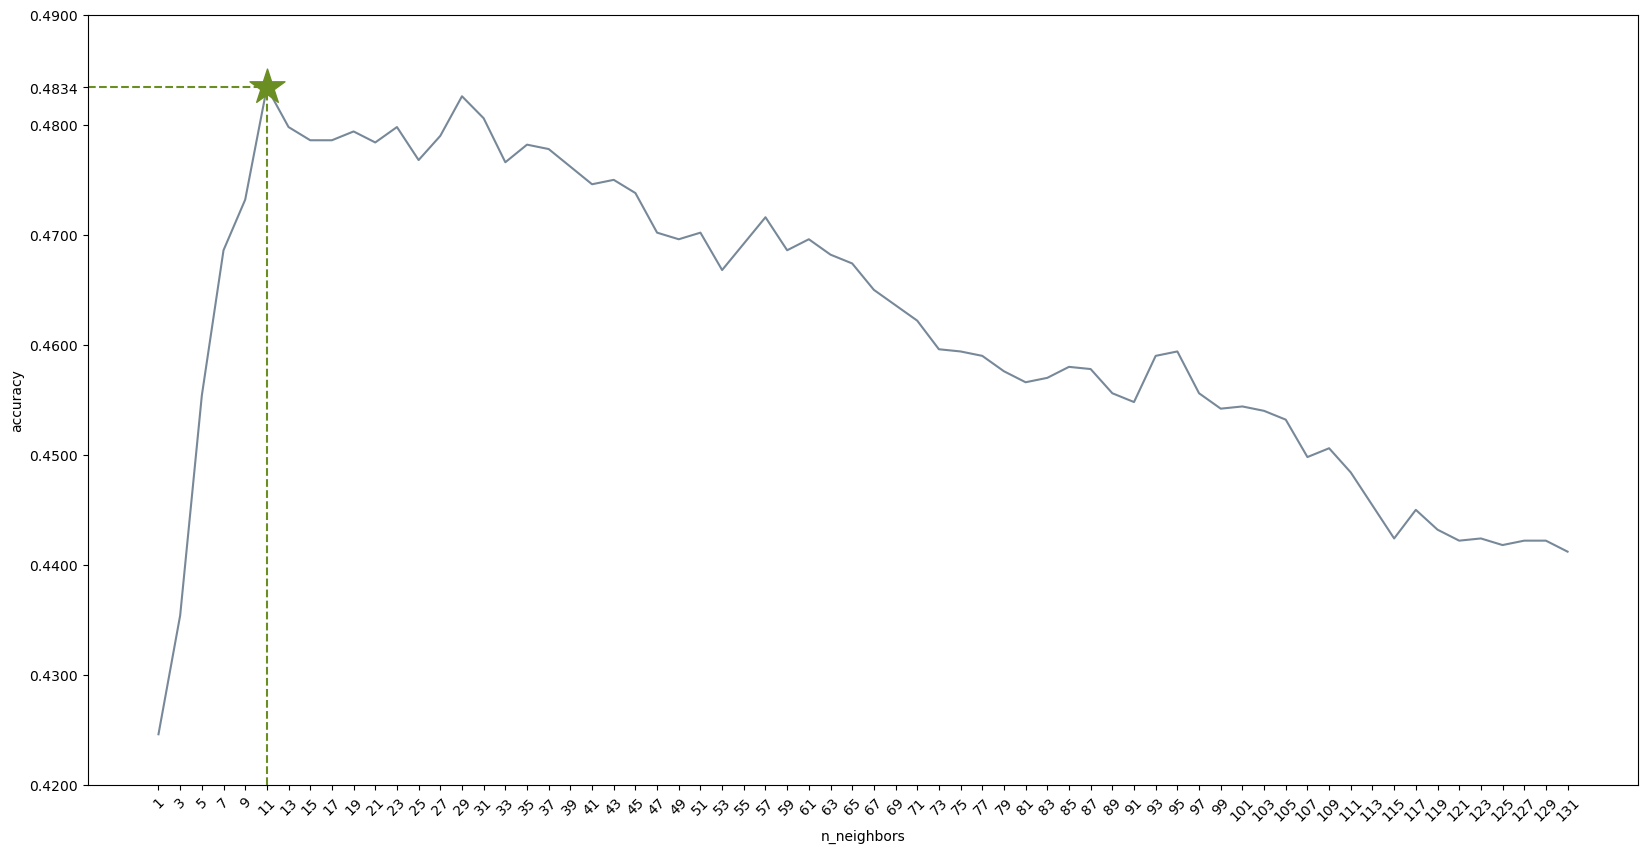

In [168]:
plt.figure(figsize=(20, 10))
plt.plot(scores, color = 'lightslategray')
plt.scatter(max_index, scores[max_index], color='olivedrab', marker = '*', s=700, zorder=5) 


plt.xticks(range(len(n_neighbors)), n_neighbors, rotation=45)
plt.yticks(list(plt.yticks()[0]) + [scores[max_index]])

plt.xlabel("n_neighbors")
plt.ylabel("accuracy")

plt.axhline(y=scores[max_index], color='olivedrab', linestyle='--', xmax = 0.12)
plt.axvline(x=max_index, color='olivedrab', linestyle='--', ymax = 0.9)

plt.show()

In [23]:
clf = KNeighborsClassifier(n_neighbors=11, metric="euclidean", weights="uniform")
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_test_pred

array(['industrial', 'idm', 'j-idol', ..., 'j-idol', 'black-metal',
       'happy'], dtype=object)

#### Performance evaluation

macro vs micro: Micro F1 score treats each instance equally, whereas macro F1 score treats each class equally

for balanced data
- $ macro = \frac1N\sum^N_i{F1_i}$ 

for imbalanced data
- $ micro = \frac{2\sum^n_iTP}{2\sum^n_i{TP}+\sum^n_i{TN}+\sum^n_i{FN}}$ 

In [45]:
print("F1:", f1_score(y_test, y_test_pred, average="macro")) 

F1: 0.4779660184536687


In [46]:
print("F1:", f1_score(y_test, y_test_pred, average="micro")) 

F1: 0.4834


In [54]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.35      0.32      0.34       250
  black-metal       0.64      0.74      0.69       250
    bluegrass       0.44      0.59      0.51       250
       brazil       0.32      0.36      0.34       250
    breakbeat       0.33      0.32      0.32       250
chicago-house       0.47      0.62      0.53       250
       disney       0.56      0.42      0.48       250
        forro       0.55      0.64      0.59       250
        happy       0.46      0.50      0.48       250
          idm       0.47      0.27      0.34       250
       indian       0.36      0.34      0.35       250
   industrial       0.31      0.29      0.30       250
      iranian       0.59      0.66      0.62       250
      j-dance       0.51      0.49      0.50       250
       j-idol       0.47      0.56      0.51       250
     mandopop       0.37      0.50      0.43       250
        sleep       0.85      0.72      0.78       250
      spa

In [62]:
report = pd.DataFrame(classification_report(y_test, y_test_pred,  output_dict=True)).transpose()
report[report['f1-score']>0.6]

,precision,recall,f1-score,support
black-metal,0.643599,0.744,0.690167,250.0
iranian,0.587814,0.656,0.620038,250.0
sleep,0.845070,0.720,0.777538,250.0
study,0.759184,0.744,0.751515,250.0


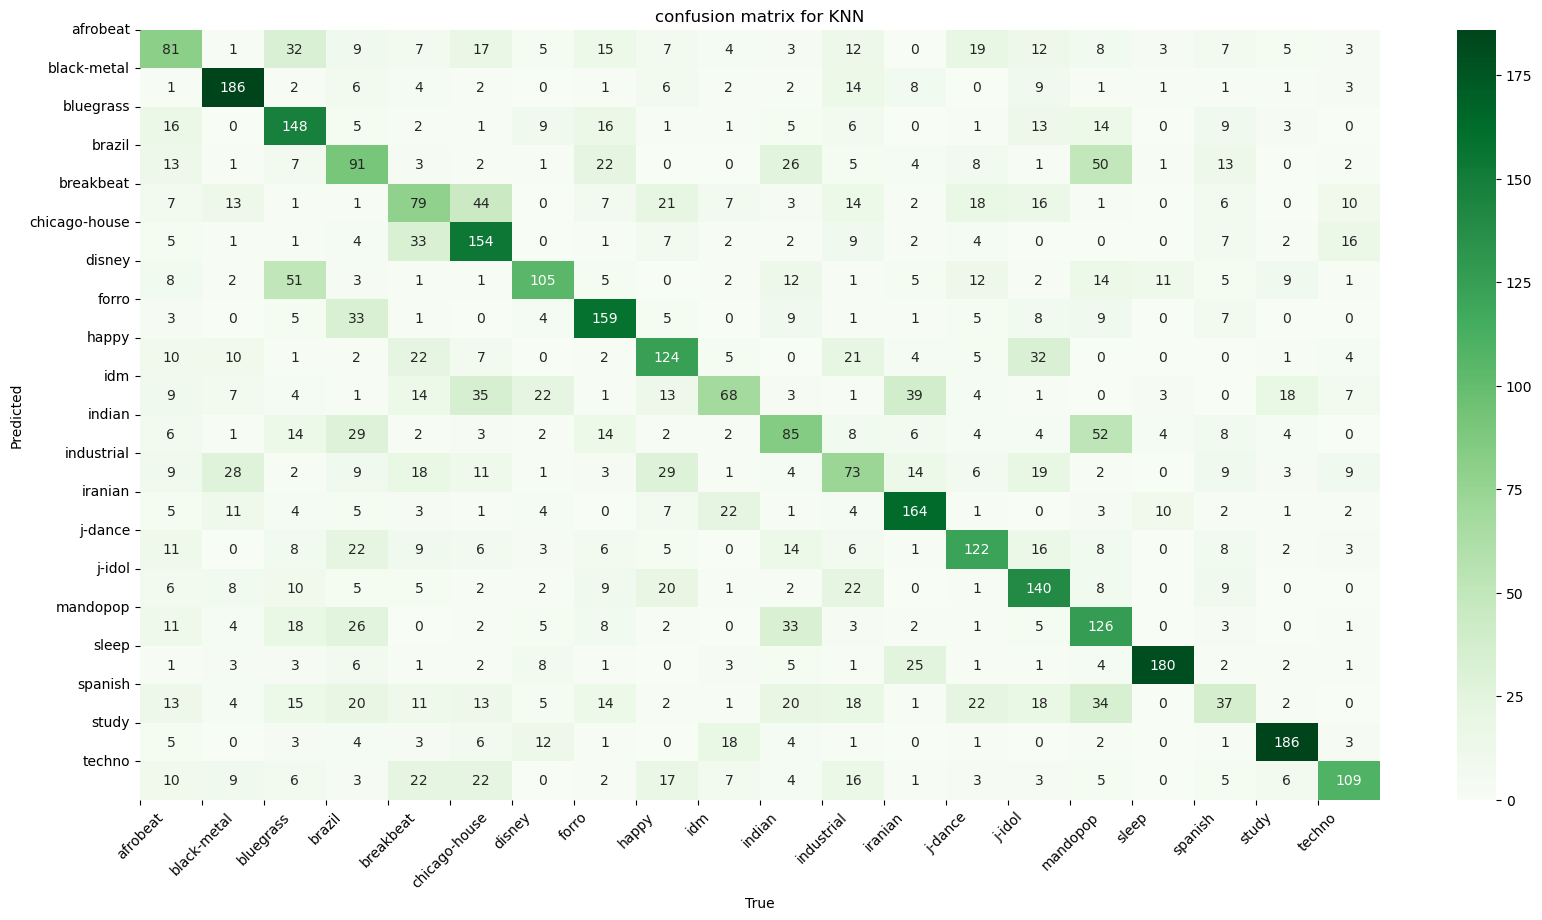

In [99]:
cf = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize = (20, 10))
sns.heatmap(cf, annot=True, cmap="Greens", fmt=".3g")

plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("confusion matrix for KNN")

plt.xticks(range(len(clf.classes_)), clf.classes_, rotation = 45)
plt.yticks(range(len(clf.classes_)), clf.classes_, rotation = 360)

plt.show()

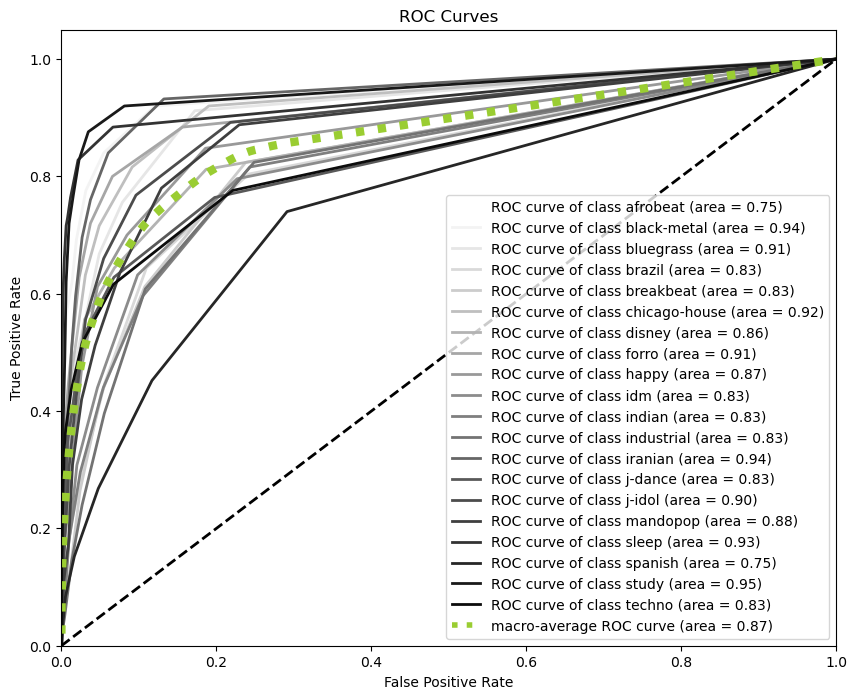

In [150]:
plot_roc_cust(y_test, clf.predict_proba(X_test))

In [151]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

0.8661624

#### Cross-validation

In [169]:
from sklearn.model_selection import cross_val_score
k = 10

In [170]:
# initialize classifier
clf = KNeighborsClassifier(n_neighbors=11, metric="euclidean", weights="uniform")

scores = cross_val_score(clf, X_train, y_train, cv=k)
scores

array([0.492     , 0.47733333, 0.47333333, 0.46466667, 0.468     ,
       0.48      , 0.47666667, 0.48933333, 0.46266667, 0.496     ])

In [171]:
print("Overall error estimate:", 1 - scores.mean())

Overall error estimate: 0.522


In [172]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.4780 (+/- 0.01)


In [174]:
# scoring default is accuracy
cross_val_score(clf, X_train, y_train, cv=k, scoring='f1_macro')

array([0.48194816, 0.46924745, 0.46546395, 0.45636227, 0.46271888,
       0.47375057, 0.47066481, 0.48541395, 0.45721449, 0.48945925])

In [175]:
len(y_test_pred[y_test_pred == y_test])/len(y_test_pred)

0.4834

#### Grid Search

In [102]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [76]:
round(X_train.shape[0]**0.5)

122

In [155]:
%%time
param_grid = {
    "n_neighbors": np.arange(1, 50, 2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    # verbose=2
)

grid.fit(X_train, y_train)
clf = grid.best_estimator_

CPU times: user 16.9 s, sys: 1.98 s, total: 18.9 s
Wall time: 11min


In [156]:
print(grid.best_params_, grid.best_score_)

{'metric': 'cityblock', 'n_neighbors': 21, 'weights': 'distance'} 0.5158400000000001


In [ ]:
# The higher the norm index, the more it focuses on large values and neglects small one
# So the euclidean is more sensitive to outliers than the cityblock.
# Maybe this explain why it wins

In [10]:
clf = KNeighborsClassifier(n_neighbors=21, metric="cityblock", weights="distance")
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_test_pred

array(['j-idol', 'techno', 'mandopop', ..., 'j-idol', 'black-metal',
       'happy'], dtype=object)

In [123]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.47      0.26      0.34       250
           1       0.68      0.74      0.71       250
           2       0.49      0.61      0.54       250
           3       0.37      0.38      0.37       250
           4       0.40      0.32      0.36       250
           5       0.52      0.68      0.59       250
           6       0.66      0.42      0.52       250
           7       0.58      0.68      0.63       250
           8       0.51      0.47      0.49       250
           9       0.51      0.29      0.37       250
          10       0.38      0.32      0.34       250
          11       0.36      0.34      0.35       250
          12       0.62      0.72      0.67       250
          13       0.55      0.51      0.53       250
          14       0.44      0.67      0.53       250
          15       0.35      0.64      0.45       250
          16       0.85      0.76      0.80       250
          17       0.32    

In [14]:
y_test_pred_proba = clf.predict_proba(X_test)
roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

0.899815410526316

In [17]:
report = pd.DataFrame(classification_report(y_test, y_test_pred,  output_dict=True)).transpose()
report[report['f1-score']>0.6].sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
sleep,0.845133,0.764,0.802521,250.0
study,0.780769,0.812,0.796078,250.0
black-metal,0.677656,0.740,0.707457,250.0
iranian,0.619863,0.724,0.667897,250.0
forro,0.583618,0.684,0.629834,250.0


In [15]:
report = pd.DataFrame(classification_report(y_test, y_test_pred,  output_dict=True)).transpose()
report.loc[report['f1-score'].nsmallest(3).index].sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
indian,0.376190,0.316,0.343478,250.0
afrobeat,0.468085,0.264,0.337596,250.0
spanish,0.321839,0.224,0.264151,250.0


In [54]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

In [59]:
df_results[(df_results['Actual'] == 'afrobeat')&(df_results['Predicted'] == 'bluegrass')].value_counts()

Actual    Predicted
afrobeat  bluegrass    34
dtype: int64

In [34]:
cf = pd.DataFrame(cf, index = clf.classes_, columns = clf.classes_)

In [38]:
worst = cf[['spanish', 'afrobeat', 'indian']]

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np

cmap = clr.LinearSegmentedColormap.from_list('custom_map', ['white', '#015697'], N=256)

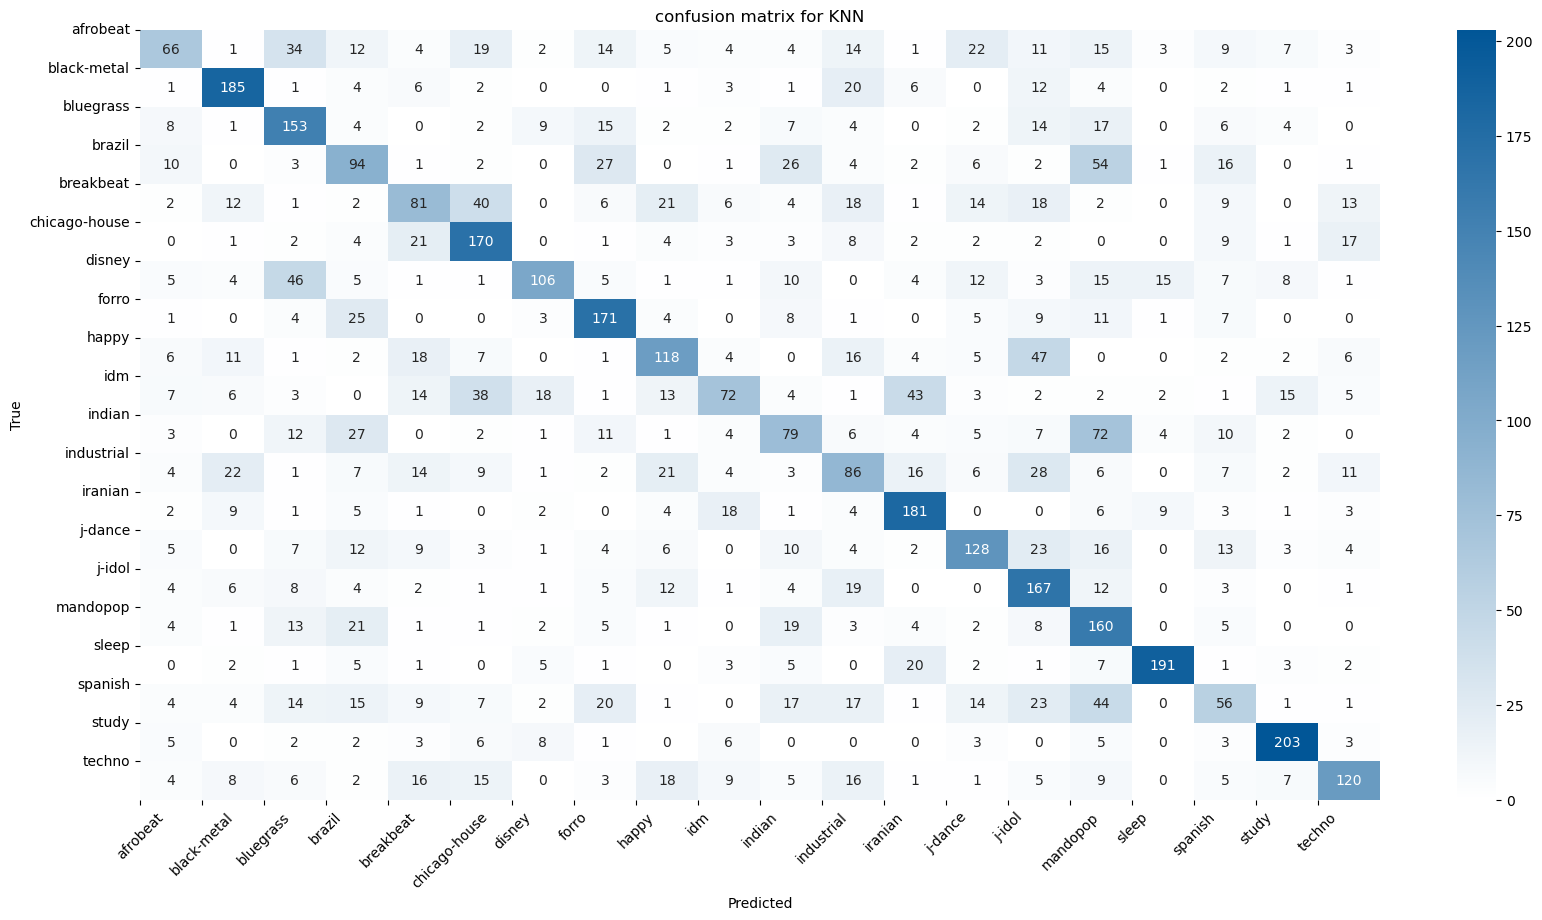

In [61]:
cf = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize = (20, 10))
sns.heatmap(cf, annot=True, cmap=cmap, fmt=".3g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("confusion matrix for KNN")

plt.xticks(range(len(clf.classes_)), clf.classes_, rotation = 45)
plt.yticks(range(len(clf.classes_)), clf.classes_, rotation = 360)

plt.show()

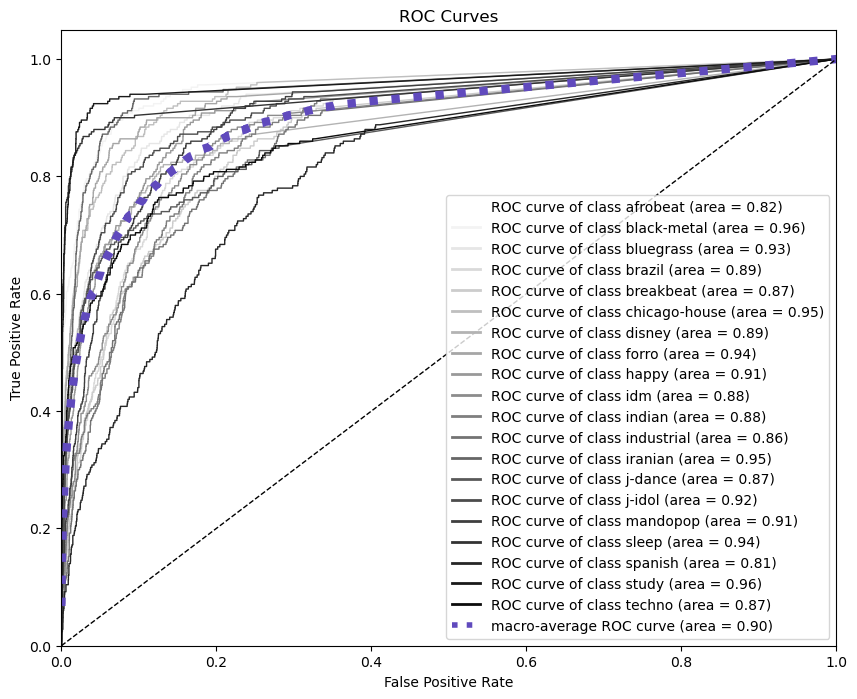

In [19]:
plot_roc_cust(y_test, clf.predict_proba(X_test))

In [100]:
median_popularity = df_train['popularity'].median()
df_train['popularity_binary'] = (df_train['popularity'] > median_popularity).astype(int)

median_popularity = df_test['popularity'].median()
df_test['popularity_binary'] = (df_test['popularity'] > median_popularity).astype(int)

df_test.head()

from sklearn.preprocessing import LabelEncoder

# label encoding Sex feature
le = LabelEncoder()
df_train['genre'] = le.fit_transform(df_train['genre'])

le = LabelEncoder()
df_test['genre'] = le.fit_transform(df_test['genre'])

to_drop = ['name', 'artists', 'album_name', 'popularity', 'popularity_confidence', 'processing','features_duration_ms', 'popularity_binary']
X_train, y_train, X_test, y_test = df_train.drop(columns=to_drop), df_train['popularity_binary'], \
                                    df_test.drop(columns=to_drop), df_test['popularity_binary']   
attributes = X_train.columns

In [103]:
param_grid = {
    "n_neighbors": np.arange(1, 50, 2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    # verbose=2
)

grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [106]:
clf

KNeighborsClassifier(metric='cityblock', n_neighbors=43, weights='distance')

In [107]:
clf = KNeighborsClassifier(metric='cityblock', n_neighbors=43, weights='distance')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_test_pred

array([0, 0, 1, ..., 1, 0, 0])

In [108]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      2594
           1       0.73      0.73      0.73      2406

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



### naive bayes

In [18]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [19]:
clf = GaussianNB()

In [20]:
%%time
clf.fit(X_train, y_train)

CPU times: user 37.5 ms, sys: 9.17 ms, total: 46.7 ms
Wall time: 46 ms


GaussianNB()

In [21]:
y_pred = clf.predict(X_test)
y_pred

array(['j-idol', 'black-metal', 'j-dance', ..., 'j-idol', 'black-metal',
       'happy'], dtype='<U13')

In [22]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     afrobeat       0.52      0.09      0.15       250
  black-metal       0.49      0.68      0.57       250
    bluegrass       0.47      0.21      0.29       250
       brazil       0.30      0.26      0.28       250
    breakbeat       0.21      0.21      0.21       250
chicago-house       0.36      0.58      0.45       250
       disney       0.43      0.37      0.40       250
        forro       0.45      0.54      0.49       250
        happy       0.33      0.37      0.35       250
          idm       0.34      0.20      0.25       250
       indian       0.27      0.06      0.09       250
   industrial       0.23      0.18      0.20       250
      iranian       0.49      0.42      0.45       250
      j-dance       0.41      0.59      0.48       250
       j-idol       0.31      0.56      0.40       250
     mandopop       0.28      0.68      0.39       250
        sleep       0.65      0.72      0.69       250
      spa

In [23]:
report = pd.DataFrame(classification_report(y_test, y_test_pred,  output_dict=True)).transpose()
report[report['f1-score']>0.6].sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
sleep,0.845133,0.764,0.802521,250.0
study,0.780769,0.812,0.796078,250.0
black-metal,0.677656,0.740,0.707457,250.0
iranian,0.619863,0.724,0.667897,250.0
forro,0.583618,0.684,0.629834,250.0


In [91]:
report = pd.DataFrame(classification_report(y_test, y_pred,  output_dict=True)).transpose()
report.loc[report['f1-score'].nsmallest(3).index]

,precision,recall,f1-score,support
indian,0.274510,0.056,0.093023,250.0
afrobeat,0.523810,0.088,0.150685,250.0
industrial,0.227273,0.180,0.200893,250.0


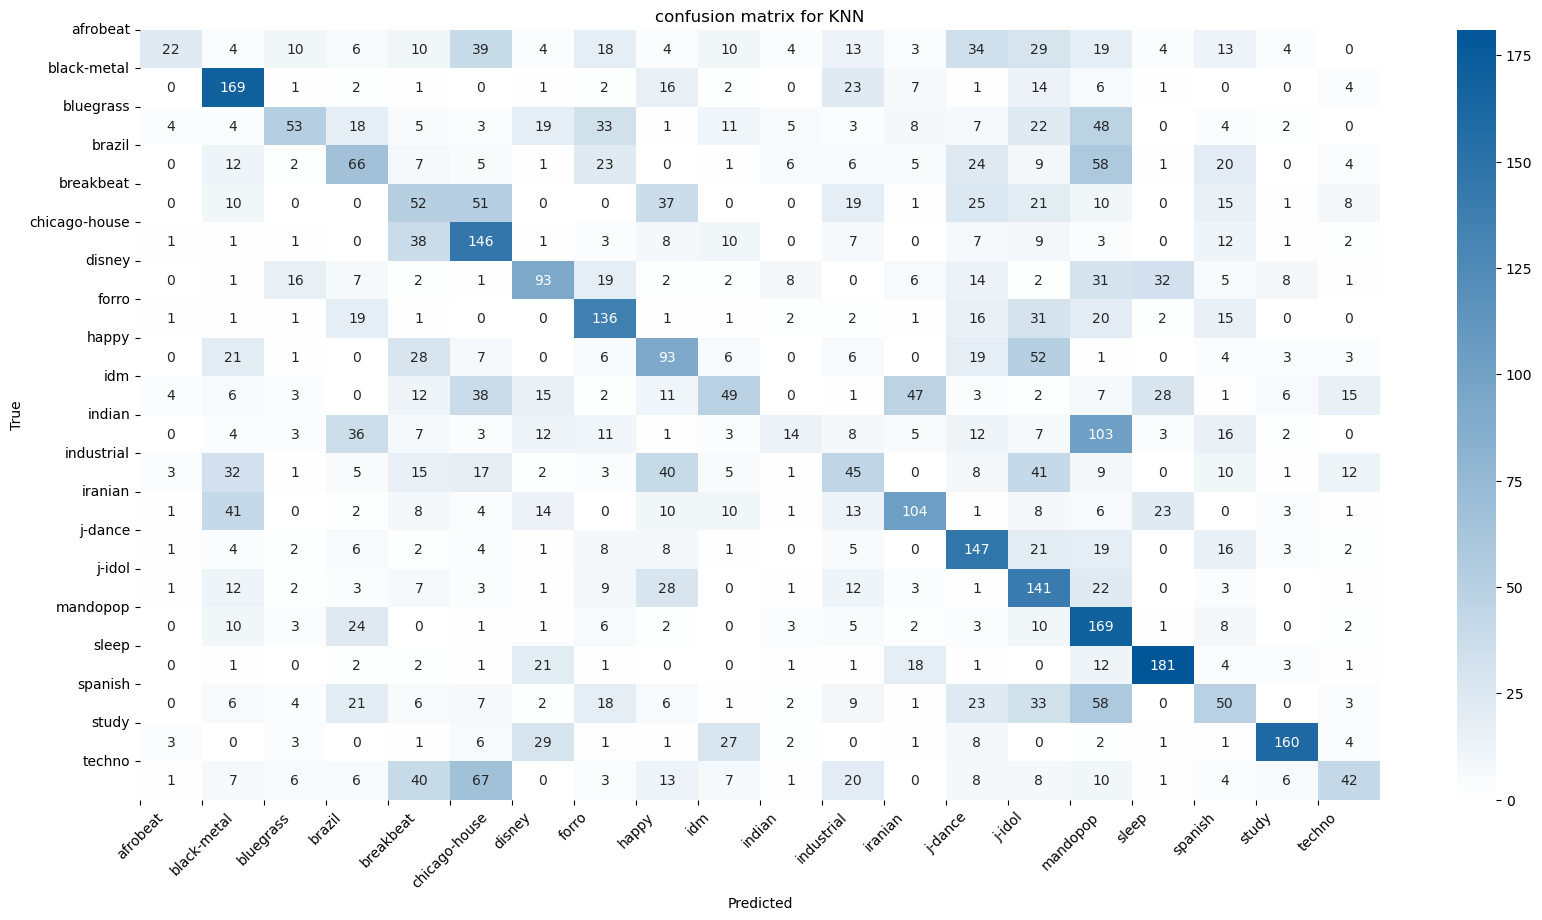

In [92]:
cf = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (20, 10))
sns.heatmap(cf, annot=True, cmap=cmap, fmt=".3g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("confusion matrix for KNN")

plt.xticks(range(len(clf.classes_)), clf.classes_, rotation = 45)
plt.yticks(range(len(clf.classes_)), clf.classes_, rotation = 360)

plt.show()

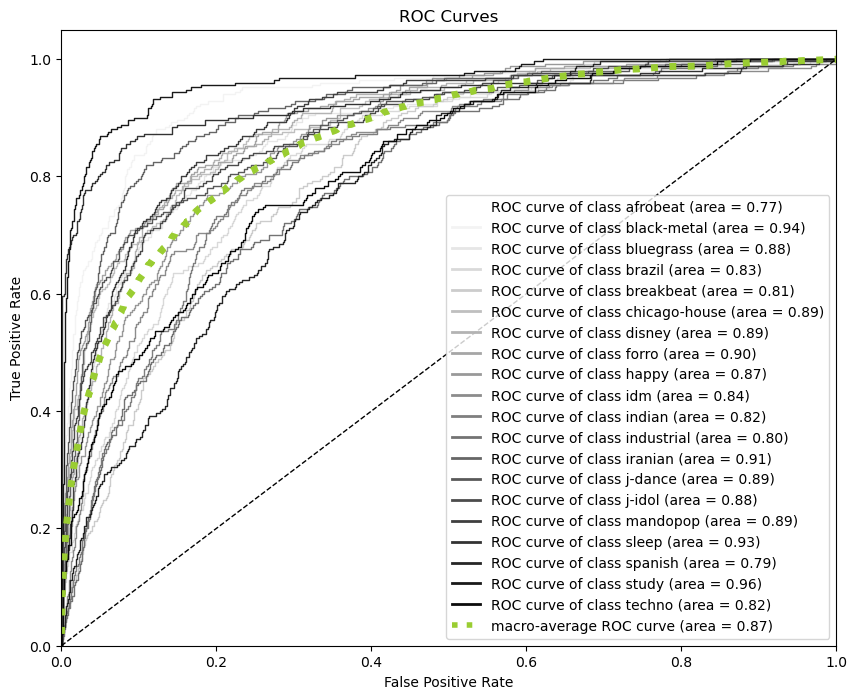

0.8655553263157897


In [52]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_test, clf.predict_proba(X_test))

print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))

#### Categorical

In [93]:
df_train.describe()
cat_col = df_train.columns[df_train.nunique() < 20].drop('processing')

In [94]:
#continuous_columns = numeric(df_train).columns

#X_noncat = df_train[continuous_columns].values


#X_train_noncat, X_test_noncat, y_train_noncat, y_test_noncat = train_test_split(
#    X_noncat, df_test[continuous_columns].values, 
#)

# train and test set should be binned separately
X_train_cat = list()
for column_idx in range(X_train.shape[1]):
    if column_idx == 7:
        X_train_cat.append(pd.qcut(X_train.iloc[:, column_idx], q=[0, 0.5, 0.65, 0.8, 1], labels=False))
        continue
    X_train_cat.append(pd.qcut(X_train.iloc[:, column_idx], q=4, labels=False))
X_train_cat = pd.DataFrame(X_train_cat).transpose()

X_test_cat = list()
for column_idx in range(X_test.shape[1]):
    if column_idx == 7:
        X_test_cat.append(pd.qcut(X_test.iloc[:, column_idx], q=[0, 0.5, 0.65, 0.8, 1], labels=False))
        continue
    X_test_cat.append(pd.qcut(X_test.iloc[:, column_idx], q=4, labels=False))
X_test_cat = pd.DataFrame(X_test_cat).transpose()

print(X_train_cat.shape, X_test_cat.shape)

(15000, 13) (5000, 13)


In [95]:
X_train_cat = pd.concat([X_train_cat, df_train[cat_col]], axis=1)
X_test_cat  = pd.concat([X_test_cat, df_test[cat_col]], axis=1)

In [135]:
X_test_cat

,duration_min,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_beats,n_bars,explicit,key,mode,time_signature
0,1,2,0,3,3,3,0,0,2,3,1,1,1,1,0,1.0,4.0
1,3,2,1,1,1,2,2,3,1,0,3,3,3,1,5,1.0,4.0
2,0,2,2,2,3,0,1,0,2,1,0,0,0,1,9,1.0,4.0
3,2,1,1,3,3,0,0,2,3,3,2,2,2,1,0,0.0,4.0
4,1,0,3,1,1,3,0,1,2,2,2,1,1,1,1,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,1,0,0,0,0,3,3,2,1,2,0,0,1,11,0.0,5.0
4996,2,0,1,2,1,2,0,0,1,1,3,2,2,1,10,0.0,4.0
4997,2,1,1,3,2,1,0,1,1,3,2,2,2,1,0,0.0,4.0
4998,3,1,0,3,3,3,0,1,0,1,0,2,2,1,2,0.0,4.0


In [96]:
clf = CategoricalNB()
clf.fit(X_train_cat, y_train)

CategoricalNB()

In [97]:
y_pred = clf.predict(X_test_cat)

In [98]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     afrobeat       0.38      0.23      0.29       250
  black-metal       0.54      0.66      0.59       250
    bluegrass       0.56      0.42      0.48       250
       brazil       0.38      0.26      0.31       250
    breakbeat       0.34      0.28      0.31       250
chicago-house       0.54      0.65      0.59       250
       disney       0.44      0.45      0.45       250
        forro       0.45      0.63      0.52       250
        happy       0.46      0.44      0.45       250
          idm       0.43      0.26      0.32       250
       indian       0.35      0.12      0.18       250
   industrial       0.34      0.32      0.33       250
      iranian       0.51      0.43      0.47       250
      j-dance       0.37      0.64      0.47       250
       j-idol       0.44      0.55      0.49       250
     mandopop       0.37      0.61      0.46       250
        sleep       0.58      0.79      0.67       250
      spa

In [155]:
report = pd.DataFrame(classification_report(y_test, y_pred,  output_dict=True)).transpose()
report[report['f1-score']>0.6]

,precision,recall,f1-score,support
sleep,0.582840,0.788,0.670068,250.0
study,0.699659,0.820,0.755064,250.0


In [99]:
report = pd.DataFrame(classification_report(y_test, y_pred,  output_dict=True)).transpose()
report.loc[report['f1-score'].nsmallest(3).index]

,precision,recall,f1-score,support
indian,0.348837,0.120,0.178571,250.0
spanish,0.227273,0.160,0.187793,250.0
afrobeat,0.379085,0.232,0.287841,250.0


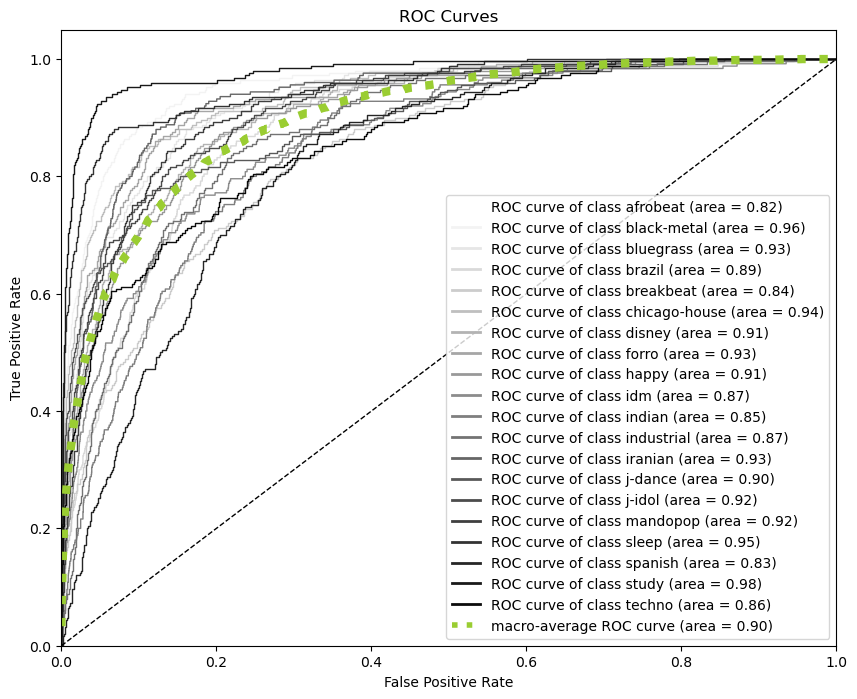

In [153]:
plot_roc_cust(y_test, clf.predict_proba(X_test_cat))

### linear regression

In [51]:
from sklearn.datasets import load_wine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [54]:
cols = X_train.columns

In [245]:
regs = []
coef = []
intercept = []
pairs = []
r2s = []

for xcol in cols:
    for ycol in cols:
        if xcol == ycol:
            continue
            
        x_train = df_train[xcol].values.reshape(-1, 1)
        y_train = df_train[ycol].values

        x_test = df_test[xcol].values.reshape(-1, 1)
        y_test = df_test[ycol].values
        
        reg = LinearRegression()
        reg.fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        
        if r2 > 0.4:
            print(f'-- {xcol}, {ycol} --')
            print('R2: %.3f' % r2)
            print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
            print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
            
            coef.append(reg.coef_)
            intercept.append(reg.intercept_)
            regs.append(reg)
            pairs.append((xcol, ycol))
            r2s.append(r2)

-- duration_min, n_beats --
R2: 0.693
MSE: 0.001
MAE: 0.019
-- duration_min, n_bars --
R2: 0.487
MSE: 0.001
MAE: 0.025
-- energy, loudness --
R2: 0.497
MSE: 0.009
MAE: 0.062
-- energy, acousticness --
R2: 0.501
MSE: 0.055
MAE: 0.183
-- loudness, energy --
R2: 0.494
MSE: 0.036
MAE: 0.144
-- acousticness, energy --
R2: 0.501
MSE: 0.035
MAE: 0.149
-- n_beats, duration_min --
R2: 0.729
MSE: 0.000
MAE: 0.013
-- n_beats, n_bars --
R2: 0.885
MSE: 0.000
MAE: 0.012
-- n_bars, duration_min --
R2: 0.525
MSE: 0.001
MAE: 0.019
-- n_bars, n_beats --
R2: 0.870
MSE: 0.000
MAE: 0.013


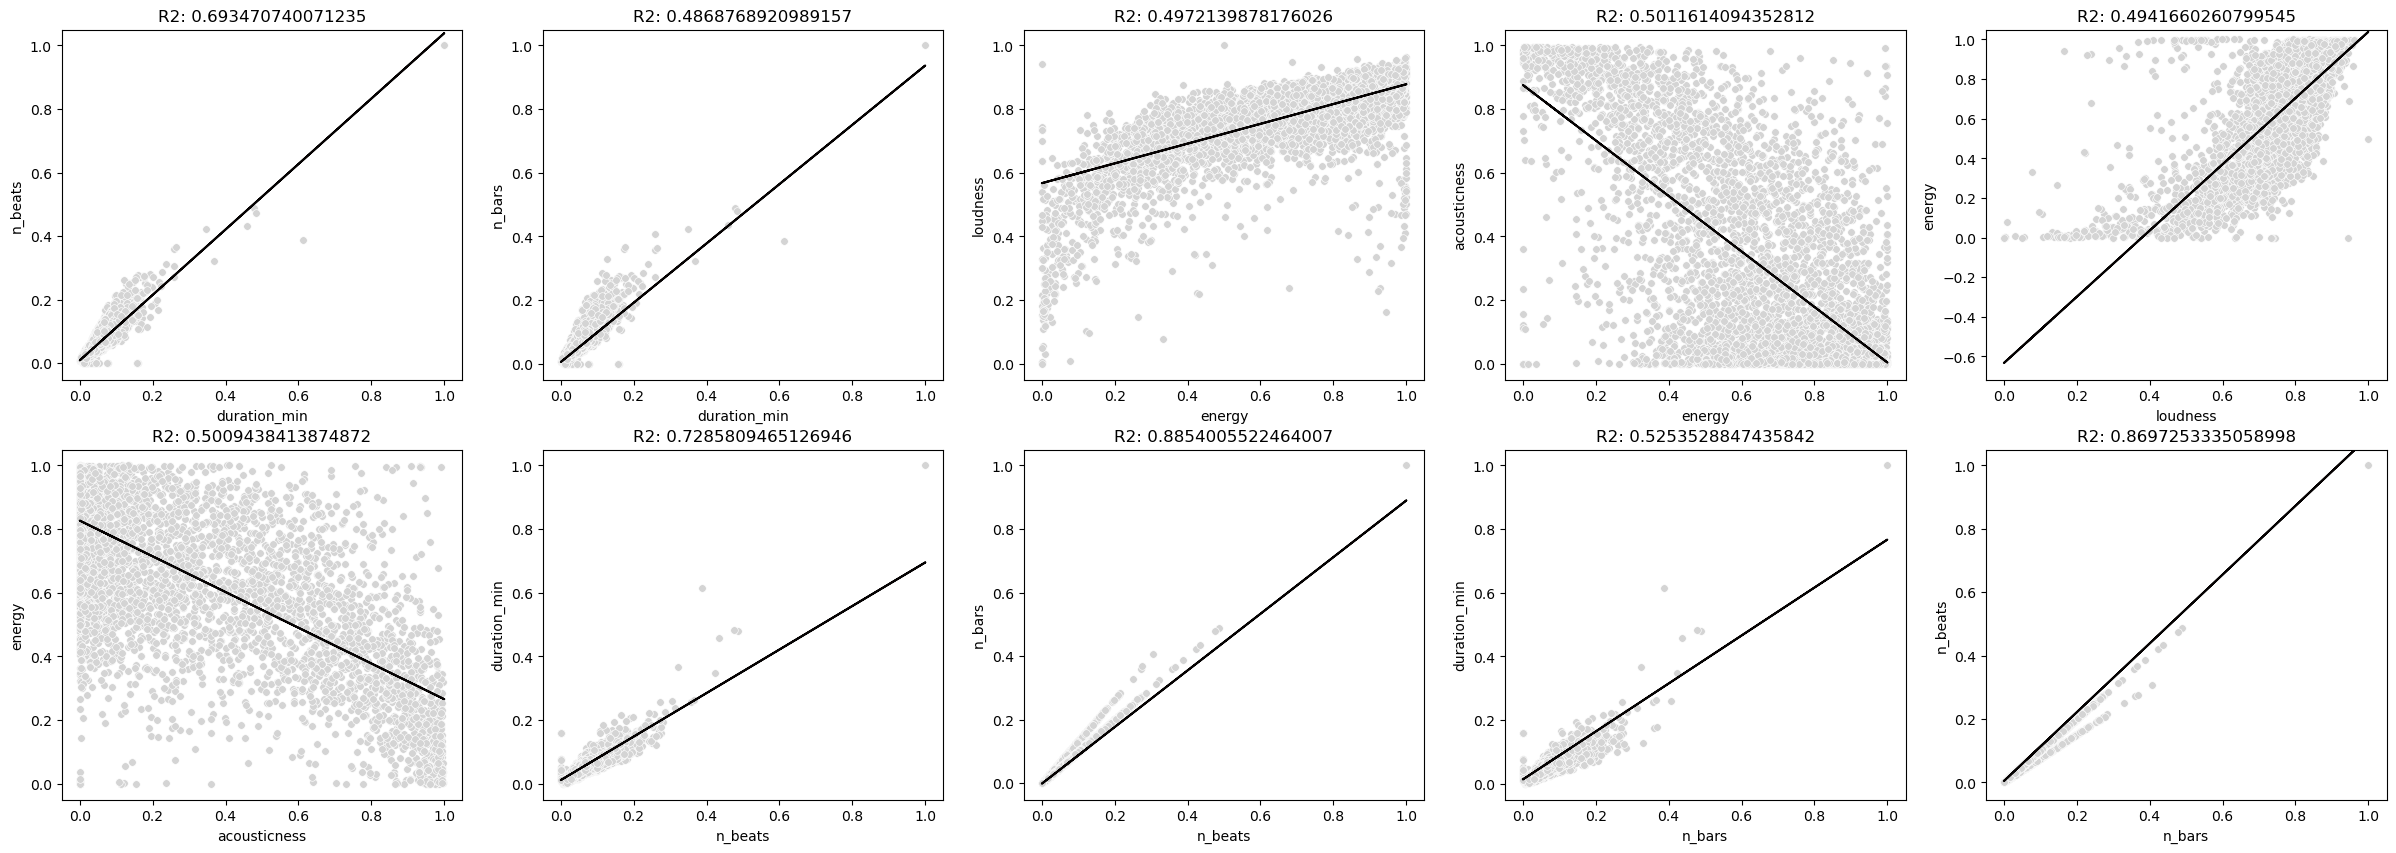

In [251]:
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

for i, pair in enumerate(pairs):
    ax = axs[i // 5, i % 5]
    
    sns.scatterplot(data=df_test, x=pair[0], y=pair[1], color = '#d4d4d4', s=30, ax=ax) 
    ax.plot(x_test, regs[i].coef_[0]*x_test+regs[i].intercept_, c="#050202")
    ax.set_title(f'R2: {r2s[i]}')
    ax.set_ylim(top = 1.05) 
    
plt.show()

### Ridge

In [252]:
regs_ridge = []
pairs_ridge = []
r2s_ridge = []

for xcol in cols:
    for ycol in cols:
        if xcol == ycol:
            continue
            
        x_train = df_train[xcol].values.reshape(-1, 1)
        y_train = df_train[ycol].values

        x_test = df_test[xcol].values.reshape(-1, 1)
        y_test = df_test[ycol].values
        
        reg = Ridge()
        reg.fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        
        if r2 > 0.45:
            print(f'-- {xcol}, {ycol} --')
            print('R2: %.3f' % r2)
            print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
            print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
            
            regs_ridge.append(reg)
            pairs_ridge.append((xcol, ycol))
            r2s_ridge.append(r2)

-- duration_min, n_beats --
R2: 0.680
MSE: 0.001
MAE: 0.019
-- duration_min, n_bars --
R2: 0.465
MSE: 0.001
MAE: 0.025
-- energy, loudness --
R2: 0.497
MSE: 0.009
MAE: 0.062
-- energy, acousticness --
R2: 0.501
MSE: 0.055
MAE: 0.183
-- loudness, energy --
R2: 0.495
MSE: 0.036
MAE: 0.144
-- acousticness, energy --
R2: 0.501
MSE: 0.035
MAE: 0.149
-- n_beats, duration_min --
R2: 0.733
MSE: 0.000
MAE: 0.013
-- n_beats, n_bars --
R2: 0.867
MSE: 0.000
MAE: 0.013
-- n_bars, duration_min --
R2: 0.564
MSE: 0.001
MAE: 0.018
-- n_bars, n_beats --
R2: 0.901
MSE: 0.000
MAE: 0.011


In [253]:
pairs_ridge == pairs

True

In [254]:
np.set_printoptions(suppress=True)
np.array(r2s) - np.array(r2s_ridge)

array([ 0.01367955,  0.02234654,  0.00012971,  0.00001388, -0.00121046,
        0.00000624, -0.0040494 ,  0.01797724, -0.03842034, -0.03108753])

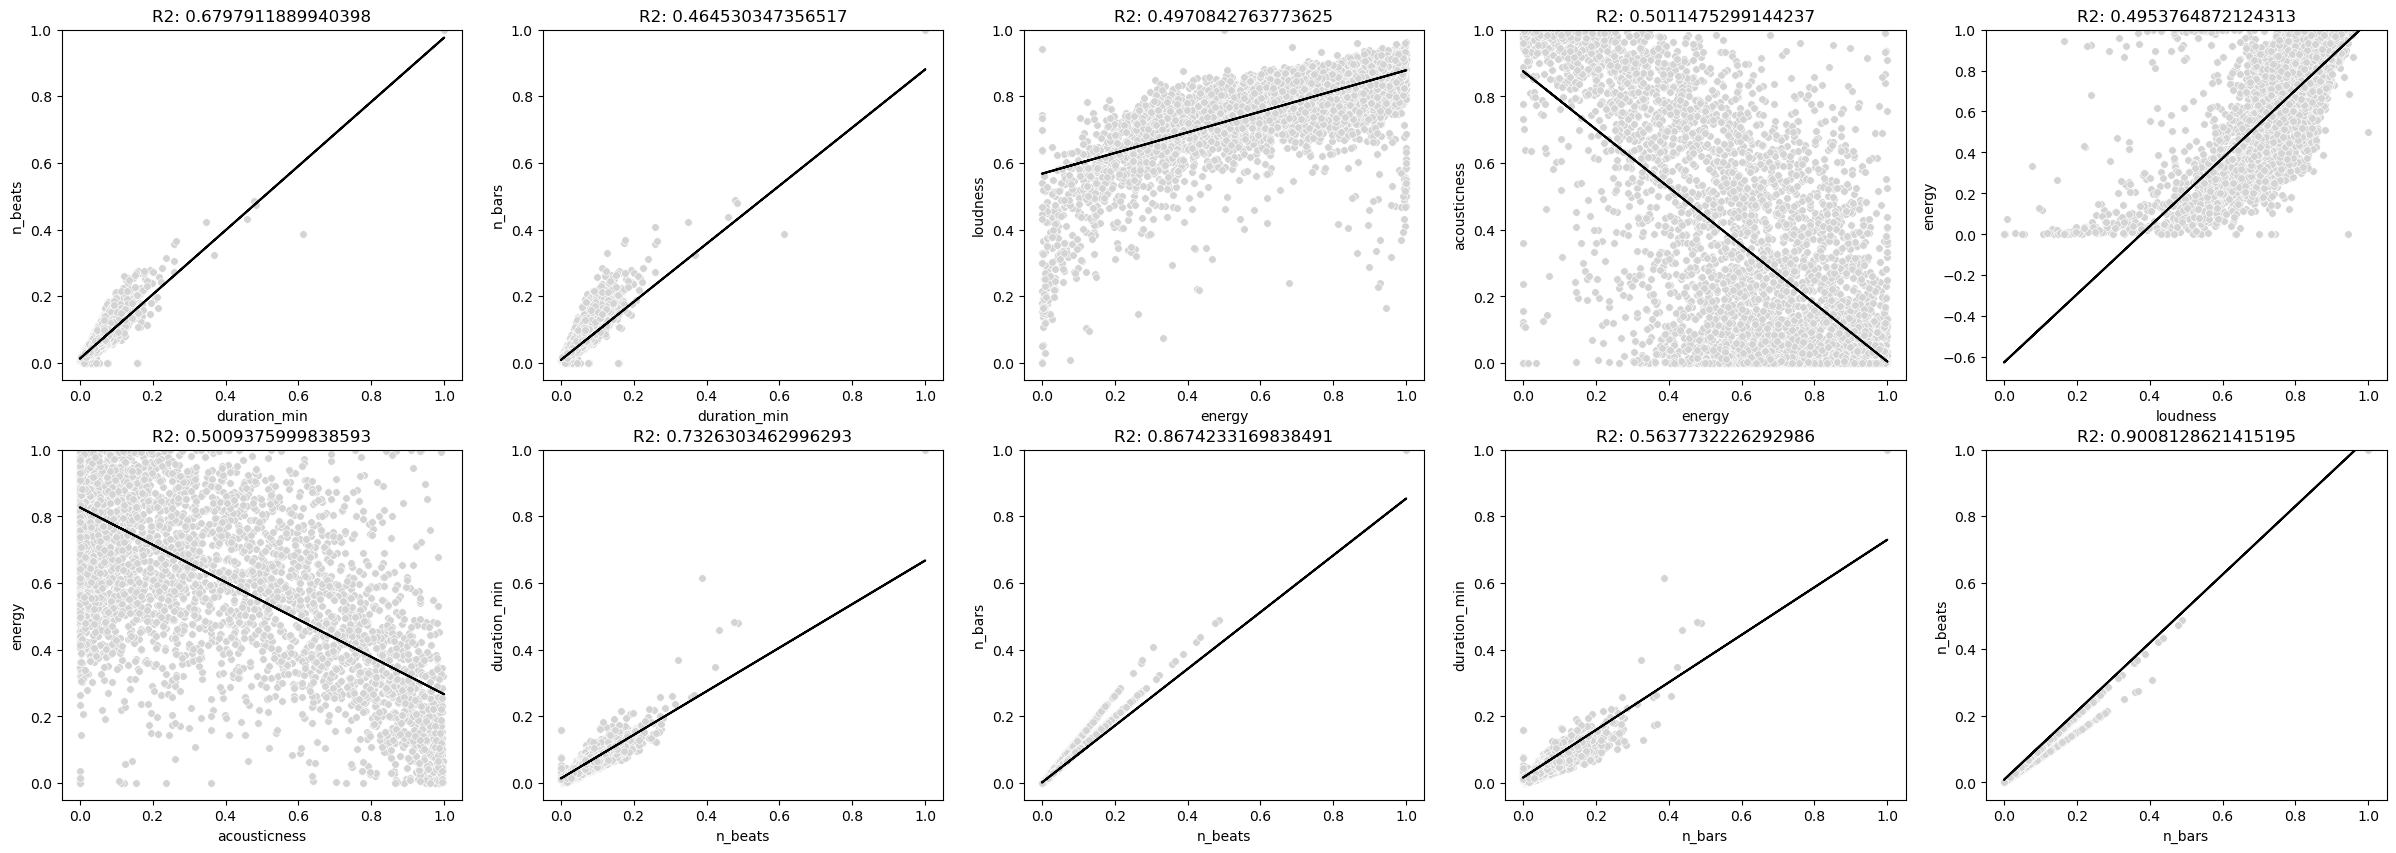

In [255]:
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

for i, pair in enumerate(pairs):
    ax = axs[i // 5, i % 5]
    
    sns.scatterplot(data=df_test, x=pair[0], y=pair[1], color = '#d4d4d4', s=30, ax=ax) 
    ax.plot(x_test, regs_ridge[i].coef_[0]*x_test+regs_ridge[i].intercept_, c="#050202")
    ax.set_title(f'R2: {r2s_ridge[i]}')
    ax.set_ylim(top = 1) 
    
plt.show()

### Lasso

In [34]:
regs_lasso = []
pairs_lasso = []
r2s_lasso = []

for xcol in cols:
    for ycol in cols:
        if xcol == ycol:
            continue
            
        x_train = df_train[xcol].values.reshape(-1, 1)
        y_train = df_train[ycol].values

        x_test = df_test[xcol].values.reshape(-1, 1)
        y_test = df_test[ycol].values
        
        reg = Lasso(alpha=0.5)
        reg.fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        

        print(f'-- {xcol}, {ycol} --')
        print('coef: %.3f' % reg.coef_)
        print('R2: %.3f' % r2)
        #print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
       # print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

        regs_lasso.append(reg)
        pairs_lasso.append((xcol, ycol))
        r2s_lasso.append(r2)

-- duration_min, popularity --
coef: -0.000
R2: -0.007
-- duration_min, danceability --
coef: -0.000
R2: -0.000
-- duration_min, energy --
coef: 0.000
R2: -0.001
-- duration_min, loudness --
coef: 0.000
R2: -0.009
-- duration_min, speechiness --
coef: -0.000
R2: -0.000
-- duration_min, acousticness --
coef: -0.000
R2: -0.000
-- duration_min, instrumentalness --
coef: 0.000
R2: -0.000
-- duration_min, liveness --
coef: -0.000
R2: -0.000
-- duration_min, valence --
coef: -0.000
R2: -0.000
-- duration_min, tempo --
coef: 0.000
R2: -0.000
-- duration_min, n_beats --
coef: 0.000
R2: -0.125
-- duration_min, n_bars --
coef: 0.000
R2: -0.323
-- popularity, duration_min --
coef: -0.000
R2: -0.016
-- popularity, danceability --
coef: 0.000
R2: -0.000
-- popularity, energy --
coef: -0.000
R2: -0.001
-- popularity, loudness --
coef: 0.000
R2: -0.009
-- popularity, speechiness --
coef: -0.000
R2: -0.000
-- popularity, acousticness --
coef: 0.000
R2: -0.000
-- popularity, instrumentalness --
coef: -

# Multiple Regression

In [56]:
X_train = numeric(df_train)
X_train

,duration_min,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_beats,n_bars
0,0.056710,0.489362,0.690,0.513,0.702298,0.0975,0.302000,0.536000,0.2810,0.6350,0.644920,0.077164,0.064977
1,0.105897,0.000000,0.069,0.196,0.469376,0.0805,0.283000,0.934000,0.3600,0.0336,0.342800,0.083968,0.071429
2,0.079024,0.031915,0.363,0.854,0.798793,0.0397,0.000089,0.800000,0.2620,0.4890,0.528865,0.088732,0.074654
3,0.063530,0.244681,0.523,0.585,0.833678,0.0765,0.066400,0.001270,0.1170,0.3850,0.638839,0.084241,0.071429
4,0.072736,0.265957,0.643,0.687,0.724866,0.0539,0.000576,0.096900,0.2990,0.6370,0.652788,0.099755,0.084332
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.102985,0.000000,0.554,0.657,0.669976,0.0558,0.016000,0.615000,0.1320,0.0335,0.531999,0.113909,0.097696
14996,0.042357,0.468085,0.103,0.860,0.567578,0.0595,0.548000,0.940000,0.1230,0.0016,0.418651,0.037697,0.042396
14997,0.095218,0.457447,0.799,0.535,0.767324,0.0594,0.001830,0.857000,0.0713,0.0708,0.571364,0.113909,0.096313
14998,0.045885,0.393617,0.511,0.970,0.896464,0.0531,0.000337,0.000014,0.4020,0.2700,0.725741,0.069815,0.059908


In [57]:
X_train = numeric(df_train).drop(columns = 'energy').values
y_train = df_train['energy'].values

X_test = numeric(df_test).drop(columns = 'energy').values
y_test = df_test['energy'].values

In [78]:
X_train_1 = numeric(df_train).drop(columns = 'energy').values
y_train_1 = df_train['energy'].values

X_test_1 = numeric(df_test).drop(columns = 'energy').values
y_test_1 = df_test['energy'].values

## Linear Regression

In [79]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [59]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.090
MSE: 0.040
MAE: 0.160


In [80]:
reg = LinearRegression()
reg.fit(X_train_1, y_train_1)

y_pred_1 = reg.predict(X_test_1)
print('R2: %.3f' % r2_score(y_test_1, y_pred_1))
print('MSE: %.3f' % mean_squared_error(y_test_1, y_pred_1))
print('MAE: %.3f' % mean_absolute_error(y_test_1, y_pred_1))

R2: 0.695
MSE: 0.021
MAE: 0.108


### Ridge

In [41]:
y_train

array([0.07716385, 0.08396843, 0.08873163, ..., 0.11390855, 0.06981492,
       0.03892216])

In [81]:
reg = Ridge()
reg.fit(X_train_1, y_train_1)

y_pred_1 = reg.predict(X_test_1)
print('R2: %.3f' % r2_score(y_test_1, y_pred_1))
print('MSE: %.3f' % mean_squared_error(y_test_1, y_pred_1))
print('MAE: %.3f' % mean_absolute_error(y_test_1, y_pred_1))

R2: 0.700
MSE: 0.021
MAE: 0.107


In [61]:
alpha = [0.5] + list(range(1, 50))

In [73]:
alpha = [0.5] + list(range(1, 51))

r2s= []

for a in alpha:
    reg = Ridge(alpha = a)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    r2s.append(r2_score(y_test, y_pred))

In [82]:
alpha = [0.5] + list(range(1, 51))

r2s= []

for a in alpha:
    reg = Ridge(alpha = a)
    reg.fit(X_train_1, y_train_1)

    y_pred_1 = reg.predict(X_test_1)
    r2s.append(r2_score(y_test_1, y_pred_1))

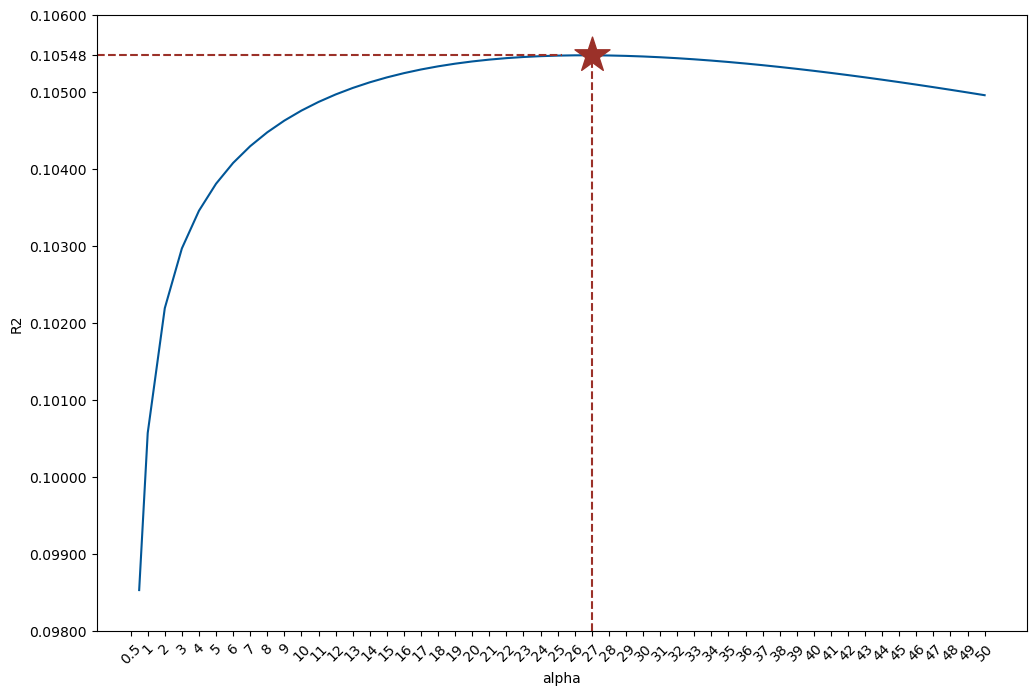

In [74]:
plt.figure(figsize = (12,8))

plt.plot(alpha, r2s, color = '#015697')
plt.scatter(r2s.index(max(r2s)), max(r2s), color=(0.60784314, 0.19215686, 0.16078431), marker = '*', s=700, zorder=5) 


plt.xticks(range(len(alpha)), alpha, rotation = 45)
plt.yticks(list(plt.yticks()[0]) + [max(r2s)])

plt.xlabel("alpha")
plt.ylabel("R2")

plt.axhline(y=max(r2s), color=(0.60784314, 0.19215686, 0.16078431), linestyle='--', xmax = 0.5)
plt.axvline(x=r2s.index(max(r2s)), color=(0.60784314, 0.19215686, 0.16078431), linestyle='--', ymax = 0.95)

plt.show()

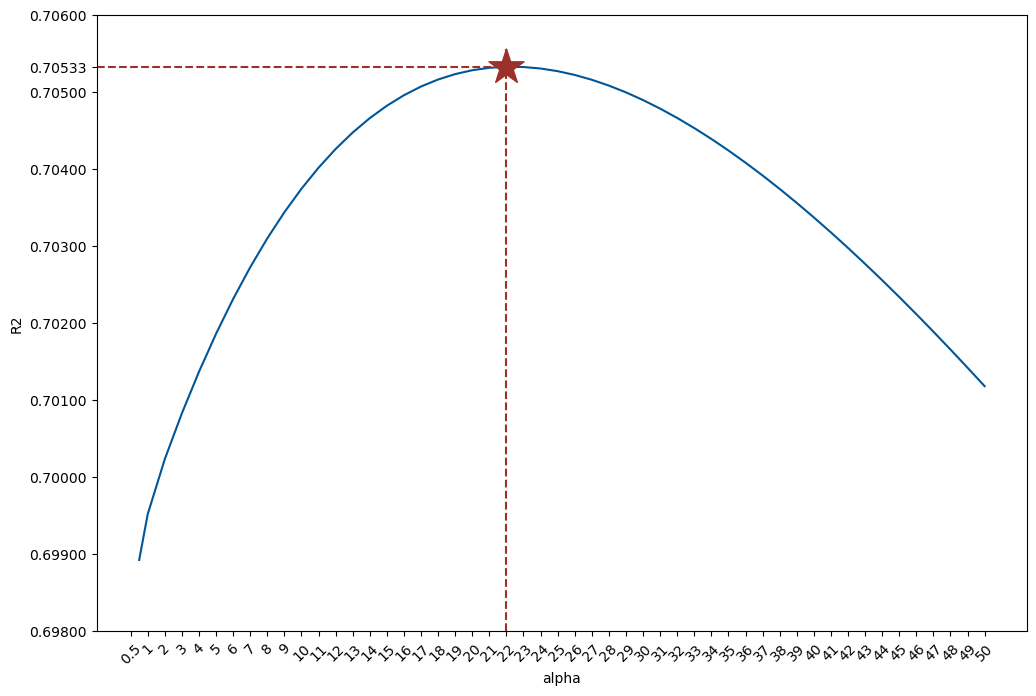

In [86]:
plt.figure(figsize = (12,8))

plt.plot(alpha, r2s, color = '#015697')
plt.scatter(r2s.index(max(r2s)), max(r2s), color=(0.60784314, 0.19215686, 0.16078431), marker = '*', s=700, zorder=5) 


plt.xticks(range(len(alpha)), alpha, rotation = 45)
plt.yticks(list(plt.yticks()[0]) + [max(r2s)])

plt.xlabel("alpha")
plt.ylabel("R2")

plt.axhline(y=max(r2s), color=(0.60784314, 0.19215686, 0.16078431), linestyle='--', xmax = 0.45)
plt.axvline(x=r2s.index(max(r2s)), color=(0.60784314, 0.19215686, 0.16078431), linestyle='--', ymax = 0.95)

plt.show()

In [72]:
reg = Ridge(alpha = 27)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.105
MSE: 0.039
MAE: 0.161


In [84]:
reg = Ridge(alpha = 22)
reg.fit(X_train_1, y_train_1)

y_pred_1 = reg.predict(X_test_1)
print('R2: %.3f' % r2_score(y_test_1, y_pred_1))
print('MSE: %.3f' % mean_squared_error(y_test_1, y_pred_1))
print('MAE: %.3f' % mean_absolute_error(y_test_1, y_pred_1))

R2: 0.705
MSE: 0.021
MAE: 0.108


### Lasso

In [348]:
reg = Lasso()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -0.007
MSE: 0.044
MAE: 0.173


In [90]:
alpha = [i * 0.05 for i in range(0, 21)]

In [92]:
alpha = [i * 0.05 for i in range(0, 21)]

r2s= []

for a in alpha:
    reg = Lasso(alpha = a)
    reg.fit(X_train_1, y_train_1)

    y_pred_1 = reg.predict(X_test_1)
    r2s.append(r2_score(y_test_1, y_pred_1))

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+02, tolerance: 1.048e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

In [94]:
max(r2s)

0.6954761178742468

In [96]:
reg = Lasso( )
reg.fit(X_train_1, y_train_1)

y_pred_1 = reg.predict(X_test_1)
print('R2: %.3f' % r2_score(y_test_1, y_pred_1))
print('MSE: %.3f' % mean_squared_error(y_test_1, y_pred_1))
print('MAE: %.3f' % mean_absolute_error(y_test_1, y_pred_1))

R2: -0.001
MSE: 0.071
MAE: 0.222


In [95]:
reg = Lasso(alpha = max(r2s) )
reg.fit(X_train_1, y_train_1)

y_pred_1 = reg.predict(X_test_1)
print('R2: %.3f' % r2_score(y_test_1, y_pred_1))
print('MSE: %.3f' % mean_squared_error(y_test_1, y_pred_1))
print('MAE: %.3f' % mean_absolute_error(y_test_1, y_pred_1))

R2: -0.001
MSE: 0.071
MAE: 0.222


# Non linear

### Decision Tree Regressor

In [75]:
from sklearn.tree import DecisionTreeRegressor

In [113]:
reg = DecisionTreeRegressor()

In [102]:
nunique = df_train.nunique()
cols = df_train.columns
categorical = [col for col in cols if nunique[col] <= 20]
objects = df_train.select_dtypes(include='object').columns

df = df_train.drop(columns = set(list(objects[:-1])+['features_duration_ms','popularity_confidence']))

In [105]:
nunique = df_test.nunique()
cols = df_test.columns
categorical = [col for col in cols if nunique[col] <= 20]
objects = df_test.select_dtypes(include='object').columns

dft = df_test.drop(columns = set(list(objects[:-1])+['features_duration_ms','popularity_confidence']))

In [108]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['genre'] = le.fit_transform(df['genre'])

le = LabelEncoder()
dft['genre'] = le.fit_transform(dft['genre'])

In [116]:
X_train_reg = df.drop(columns = ['energy'])
y_train_reg = df['energy']

X_test_reg = dft.drop(columns = ['energy'])
y_test_reg = dft['energy']

In [117]:
reg.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor()

In [308]:
y_pred = reg.predict(X_test_reg)
print('R2: %.3f' % r2_score(y_test_reg, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test_reg, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test_reg, y_pred))

R2: -0.429
MSE: 0.063
MAE: 0.193


In [126]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

param_list = {
    'max_depth': list(np.arange(2, 30)),
    'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'criterion': ['squared_error']
}

# default: clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeRegressor(),
    param_distributions=param_list,
    cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)



random_search.fit(X_train_reg, y_train_reg)
random_search.best_estimator_

DecisionTreeRegressor(max_depth=27, min_samples_leaf=30, min_samples_split=50)

In [130]:
reg = DecisionTreeRegressor(max_depth=27, min_samples_leaf=30, min_samples_split=50, criterion = 'squared_error')

In [131]:
reg.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor(max_depth=27, min_samples_leaf=30, min_samples_split=50)

In [132]:
y_pred = reg.predict(X_test_reg)
print('R2: %.3f' % r2_score(y_test_reg, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test_reg, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test_reg, y_pred))

R2: 0.756
MSE: 0.017
MAE: 0.093


### KNN Regressor

In [133]:
from sklearn.neighbors import KNeighborsRegressor

In [139]:
reg = KNeighborsRegressor()

In [137]:
categorical

['explicit', 'key', 'mode', 'time_signature', 'processing', 'genre']

In [138]:
X_train_knn = X_train_reg.drop(columns = categorical)
y_train_knn = y_train_reg
X_test_knn = X_test_reg.drop(columns = categorical)
y_test_knn = y_test_reg

In [143]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

round(X_train.shape[0]**0.5)


param_grid = {
    "n_neighbors": np.arange(1, 50, 2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid=param_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=0),
    n_jobs=-1,
    refit=True,
    # verbose=2
)

grid.fit(X_train_knn, y_train_knn)
clf = grid.best_estimator_

In [144]:
clf

KNeighborsRegressor(metric='cityblock', n_neighbors=15, weights='distance')

In [146]:
reg = KNeighborsRegressor(metric='cityblock', n_neighbors=15, weights='distance')
reg.fit(X_train_knn, y_train_knn)

KNeighborsRegressor(metric='cityblock', n_neighbors=15, weights='distance')

In [141]:
y_pred = reg.predict(X_test_knn)
print('R2: %.3f' % r2_score(y_test_knn, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test_knn, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test_knn, y_pred))

R2: 0.741
MSE: 0.018
MAE: 0.100


In [147]:
y_pred = reg.predict(X_test_knn)
print('R2: %.3f' % r2_score(y_test_knn, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test_knn, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test_knn, y_pred))

R2: 0.770
MSE: 0.016
MAE: 0.094


### multivariate

In [148]:
X_train_knn

,duration_min,popularity,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_beats,n_bars
0,0.056710,0.489362,0.690,0.702298,0.0975,0.302000,0.536000,0.2810,0.6350,0.644920,0.077164,0.064977
1,0.105897,0.000000,0.069,0.469376,0.0805,0.283000,0.934000,0.3600,0.0336,0.342800,0.083968,0.071429
2,0.079024,0.031915,0.363,0.798793,0.0397,0.000089,0.800000,0.2620,0.4890,0.528865,0.088732,0.074654
3,0.063530,0.244681,0.523,0.833678,0.0765,0.066400,0.001270,0.1170,0.3850,0.638839,0.084241,0.071429
4,0.072736,0.265957,0.643,0.724866,0.0539,0.000576,0.096900,0.2990,0.6370,0.652788,0.099755,0.084332
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.102985,0.000000,0.554,0.669976,0.0558,0.016000,0.615000,0.1320,0.0335,0.531999,0.113909,0.097696
14996,0.042357,0.468085,0.103,0.567578,0.0595,0.548000,0.940000,0.1230,0.0016,0.418651,0.037697,0.042396
14997,0.095218,0.457447,0.799,0.767324,0.0594,0.001830,0.857000,0.0713,0.0708,0.571364,0.113909,0.096313
14998,0.045885,0.393617,0.511,0.896464,0.0531,0.000337,0.000014,0.4020,0.2700,0.725741,0.069815,0.059908


In [152]:
X_train_multi, X_test_multi = X_train_knn.drop(columns = 'danceability'), X_test_knn.drop(columns = 'danceability')
Y_train_multi = df_train[['danceability', 'energy']]
Y_test_multi = df_test[['danceability', 'energy']]

In [157]:
param_grid = {
    "n_neighbors": np.arange(1, 50, 2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid=param_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=0),
    n_jobs=-1,
    refit=True,
    # verbose=2
)

grid.fit(X_train_multi, Y_train_multi)
clf = grid.best_estimator_

In [158]:
clf

KNeighborsRegressor(metric='cityblock', n_neighbors=17, weights='distance')

In [159]:
reg = KNeighborsRegressor(metric='cityblock', n_neighbors=17, weights='distance')
reg.fit(X_train_multi, Y_train_multi)

KNeighborsRegressor(metric='cityblock', n_neighbors=17, weights='distance')

In [160]:
y_pred = reg.predict(X_test_multi)
print('R2: %.3f' % r2_score(Y_test_multi, y_pred))
print('MSE: %.3f' % mean_squared_error(Y_test_multi, y_pred))
print('MAE: %.3f' % mean_absolute_error(Y_test_multi, y_pred))

R2: 0.676
MSE: 0.016
MAE: 0.096


In [328]:
y_pred = reg.predict(X_test_multi)
print('R2: %.3f' % r2_score(Y_test_multi, y_pred))
print('MSE: %.3f' % mean_squared_error(Y_test_multi, y_pred))
print('MAE: %.3f' % mean_absolute_error(Y_test_multi, y_pred))

R2: 0.303
MSE: 0.020
MAE: 0.086
